In [1]:
!nvidia-smi

Sat May  8 11:49:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F

In [3]:
#Converting data to torch.FloatTensor
transform = transforms.ToTensor()

# Download the training and test datasets
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)

test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
#Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0)

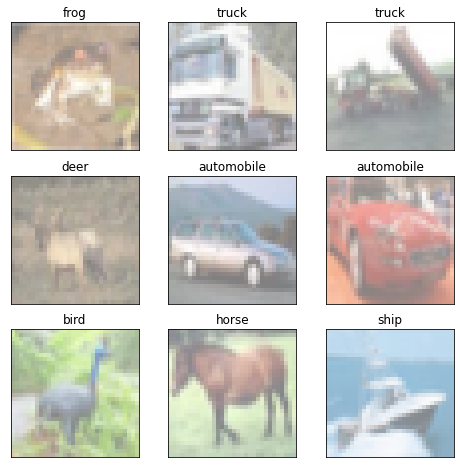

In [5]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

 
#Define the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [6]:
#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
              
        return x


#Instantiate the model
model = ConvAutoencoder()
print(model)


ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [7]:
#Loss function
criterion = nn.BCELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cuda:0


ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)

In [11]:
#Epochs
n_epochs = 100

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} of {} \tTraining Loss: {:.6f}'.format(epoch, n_epochs, train_loss))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 of 100 	Training Loss: 18.037465
Epoch: 2 of 100 	Training Loss: 18.037122
Epoch: 3 of 100 	Training Loss: 18.036808
Epoch: 4 of 100 	Training Loss: 18.036505
Epoch: 5 of 100 	Training Loss: 18.036213
Epoch: 6 of 100 	Training Loss: 18.035935
Epoch: 7 of 100 	Training Loss: 18.035669
Epoch: 8 of 100 	Training Loss: 18.035412
Epoch: 9 of 100 	Training Loss: 18.035169
Epoch: 10 of 100 	Training Loss: 18.034937
Epoch: 11 of 100 	Training Loss: 18.034714
Epoch: 12 of 100 	Training Loss: 18.034507
Epoch: 13 of 100 	Training Loss: 18.034303
Epoch: 14 of 100 	Training Loss: 18.034106
Epoch: 15 of 100 	Training Loss: 18.033916
Epoch: 16 of 100 	Training Loss: 18.033739
Epoch: 17 of 100 	Training Loss: 18.033562
Epoch: 18 of 100 	Training Loss: 18.033397
Epoch: 19 of 100 	Training Loss: 18.033233
Epoch: 20 of 100 	Training Loss: 18.033077
Epoch: 21 of 100 	Training Loss: 18.032921
Epoch: 22 of 100 	Training Loss: 18.032776
Epoch: 23 of 100 	Training Loss: 18.032629
Epoch: 24 of 100 	Tr

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Original Images


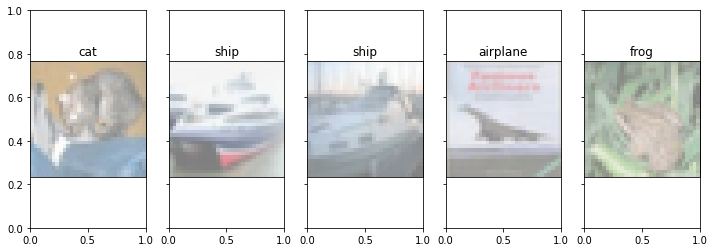

Reconstructed Images


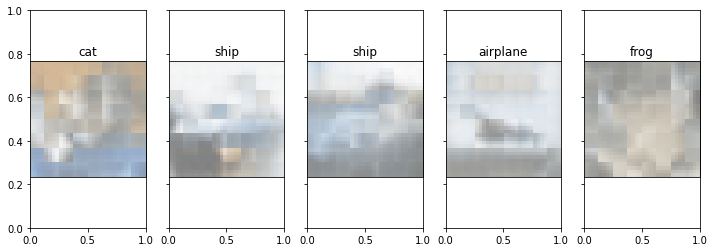

<Figure size 432x288 with 0 Axes>

In [20]:
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

#Sample outputs
output = model(images.to(device))

images = images.numpy()

output = output.view(32, 3, 32, 32)
#output = output.detach().numpy()
output = output.detach().cpu()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show() 
plt.savefig('image_sample.png')